In [2]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import pyproj
from shapely.affinity import scale
import folium
import shutil

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from data_collection import *
from functions import *

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Shapefile specifications

In [26]:
source_folder = '../data/external/shp/rivers/'
source_folder = '../data/external/shp/rivers/LaBroye_shapefile'

In [34]:
rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    if len(dirs) == 0:
        river = gpd.read_file(subdir)
        original_crs = river.crs
        river = river.to_crs("EPSG:4326")
        print(subdir)
        rivers[subdir.split('/')[-1]] = river
        print(river.shape)

../data/external/shp/rivers/LaBroye_shapefile
(62, 16)


In [28]:
rivers.keys()

dict_keys(['LaBroye_shapefile'])

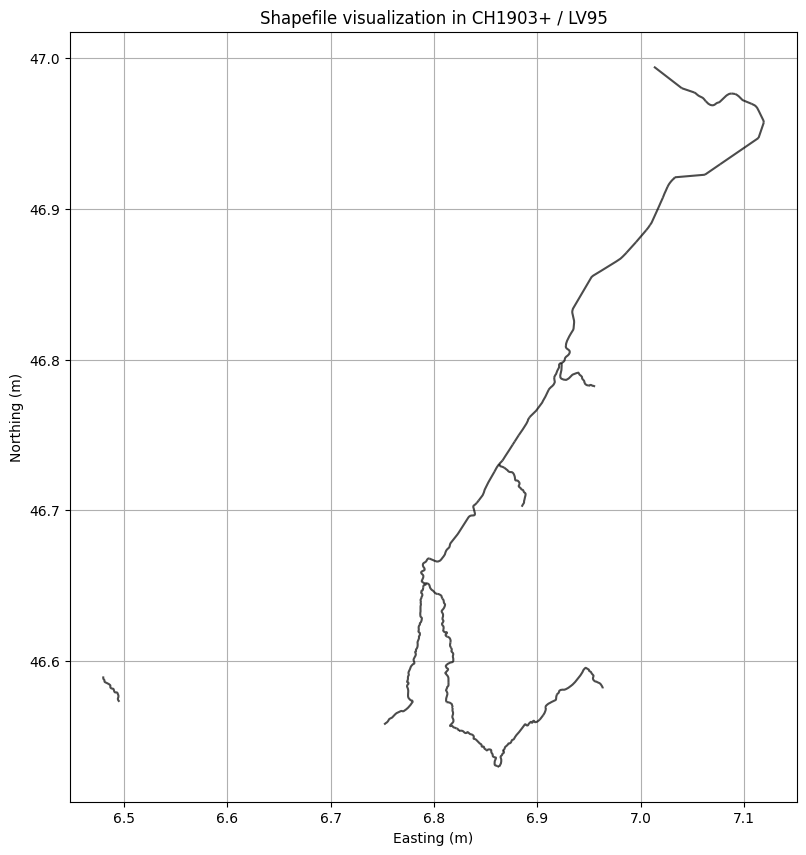

In [35]:
for r in rivers.values():
    fig, ax = plt.subplots(figsize=(10, 10))
    r.plot(ax=ax, edgecolor='k', alpha=0.7)
    ax.set_title('Shapefile visualization in CH1903+ / LV95')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.grid(True)
    plt.show()

### Fix shapefiles coordinates

/var/folders/lx/01q73krn1md9zqcwvy3rqlqh0000gn/T/ipykernel_29446/1100672989.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


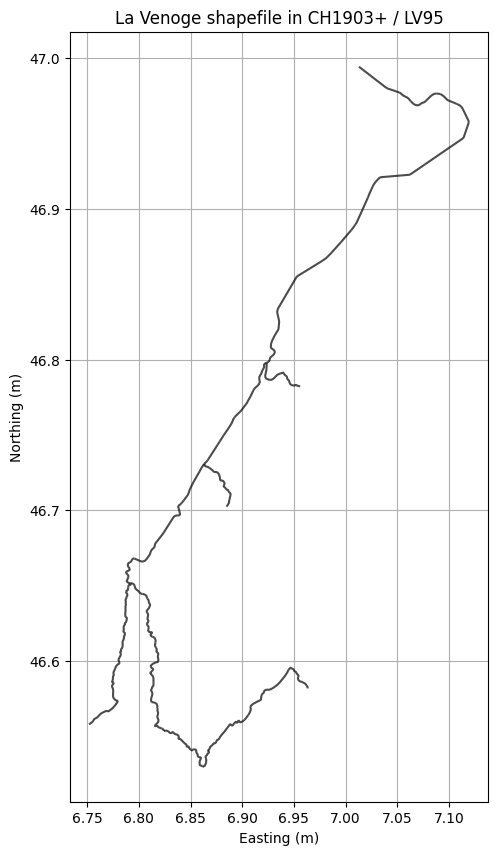

In [36]:
for k, r in rivers.items():
    # Load the shapefile
    gdf = r

    # Calculate the centroid of all LineStrings
    centroid = gdf.unary_union.centroid

    # Calculate the distance of each LineString to the centroid
    gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)

    # Option 1: Remove LineStrings that are farther than the 90th percentile distance
    threshold_distance = gdf['distance_to_centroid'].quantile(0.99)

    # Filter LineStrings closer to the centroid (within the threshold)
    filtered_gdf = gdf[gdf['distance_to_centroid'] <= threshold_distance]

    # Option 2: You can also set a manual threshold, e.g., 500 meters
    # filtered_gdf = gdf[gdf['distance_to_centroid'] <= 500]
    rivers[k] = filtered_gdf

    fig, ax = plt.subplots(figsize=(10, 10))
    rivers[k].plot(ax=ax, edgecolor='k', alpha=0.7)
    ax.set_title('La Venoge shapefile in CH1903+ / LV95')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.grid(True)
    plt.show()

## Obtain LST images

Load the water temperature database filtered by dates and regions.

In [16]:
gdf_points = gpd.read_file('../data/external/wt_filtered.geojson')

In [17]:
gdf_points.describe()

,time,longitude,latitude,waterTemperature
count,130626,130626.000000,130626.000000,130626.000000
mean,2016-08-14 21:39:30.731707392,8.208333,46.791667,8.107535
min,2013-03-31 00:00:00,5.791666,45.708332,0.100000
25%,2014-11-30 00:00:00,6.958334,46.208332,2.446680
50%,2016-08-15 12:00:00,8.208333,46.791668,6.805704
75%,2018-04-30 00:00:00,9.458333,47.375000,12.901316
max,2019-12-31 00:00:00,10.625000,47.875000,26.724939
std,NaN,1.419121,0.649076,6.413499


In [18]:
unique_dates = gdf_points.time.dt.strftime('%Y-%m').unique()

In [19]:
unique_dates

array(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12'],

#### Evalscript and sentinelhub request

In [12]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: { bands: 3 }
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [20]:
slots = []

for date in unique_dates:
  year = int(date.split('-')[0])
  month = int(date.split('-')[1])
  fd = first_day(month, year)
  ld = last_day(fd)
  slots.append( (fd.isoformat(), ld.isoformat()) )

slots

[('2013-03-01', '2013-03-31'),
 ('2013-04-01', '2013-04-30'),
 ('2013-05-01', '2013-05-31'),
 ('2013-06-01', '2013-06-30'),
 ('2013-07-01', '2013-07-31'),
 ('2013-08-01', '2013-08-31'),
 ('2013-09-01', '2013-09-30'),
 ('2013-10-01', '2013-10-31'),
 ('2013-11-01', '2013-11-30'),
 ('2013-12-01', '2013-12-31'),
 ('2014-01-01', '2014-01-31'),
 ('2014-02-01', '2014-02-28'),
 ('2014-03-01', '2014-03-31'),
 ('2014-04-01', '2014-04-30'),
 ('2014-05-01', '2014-05-31'),
 ('2014-06-01', '2014-06-30'),
 ('2014-07-01', '2014-07-31'),
 ('2014-08-01', '2014-08-31'),
 ('2014-09-01', '2014-09-30'),
 ('2014-10-01', '2014-10-31'),
 ('2014-11-01', '2014-11-30'),
 ('2014-12-01', '2014-12-31'),
 ('2015-01-01', '2015-01-31'),
 ('2015-02-01', '2015-02-28'),
 ('2015-03-01', '2015-03-31'),
 ('2015-04-01', '2015-04-30'),
 ('2015-05-01', '2015-05-31'),
 ('2015-06-01', '2015-06-30'),
 ('2015-07-01', '2015-07-31'),
 ('2015-08-01', '2015-08-31'),
 ('2015-09-01', '2015-09-30'),
 ('2015-10-01', '2015-10-31'),
 ('2015-

### Download the data

Clean directories

In [14]:
raw_data_path = '../data/raw/lst'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

In [ ]:
for k, river in rivers.items():
    destination_folder = f'../data/raw/lst/{k}'
    get_data(river, evalscript_lst, slots, 'lst', destination_folder)
    
    # Inicializa un contador para renombrar las imágenes
    counter = 0

    # Recorre todas las subcarpetas en la carpeta principal
    for subdir, dirs, files in os.walk(destination_folder):
        for file in files:
            # Si el archivo es un .tiff
            if file.endswith('.tiff'):
                # Construye la ruta completa del archivo tiff
                tiff_file_path = os.path.join(subdir, file)

                # Define el nuevo nombre del archivo
                new_file_name = f'image_{slots[counter][0][:7]}.tiff'
                new_file_path = os.path.join(destination_folder, new_file_name)

                # Mueve el archivo al nuevo directorio con el nuevo nombre
                shutil.move(tiff_file_path, new_file_path)
                
                # Incrementa el contador
                counter += 1
    

    for subdir, dirs, files in os.walk(destination_folder):
        for dir in dirs:
            dir_path = os.path.join(subdir, dir)
            shutil.rmtree(dir_path, ignore_errors=True)



## Obtain WT images

Divide quadrants and link them to its closest point in the database. If there is a point in the quadrant, return it. Else, calculate the closest point with euclidian distance

In [21]:
for k, river in rivers.items():
    # Define el bbox del cuadrado
    #bbox = [lat_min, lon_min, lat_max, lon_max]
    lon_min, lat_min, lon_max, lat_max = river.total_bounds

    # Calcula el centro de cada cuadrante
    lat_mid = (lat_min + lat_max) / 2
    lon_mid = (lon_min + lon_max) / 2

    # Definir los cuadrantes como cajas de límites (bounding boxes)
    quadrants = {
        'upper_left': [lat_mid, lon_min, lat_max, lon_mid],  # lat_max y lon_mid
        'upper_right': [lat_mid, lon_mid, lat_max, lon_max],  # lat_max y lon_max
        'lower_left': [lat_min, lon_min, lat_mid, lon_mid],  # lat_min y lon_mid
        'lower_right': [lat_min, lon_mid, lat_mid, lon_max]  # lat_min y lon_max
    }

    # Crear un mapa centrado en el área de interés
    m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=13)

    # Dibujar el bounding box (cuadrado principal)
    bounding_box = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")

    # Dibujar los cuadrantes y encontrar puntos más cercanos
    closest_points = {}
    for quadrant_name, quadrant_bbox in quadrants.items():
        # Dibujar cada cuadrante
        quadrant_box = box(quadrant_bbox[1], quadrant_bbox[0], quadrant_bbox[3], quadrant_bbox[2])
        gdf_quadrant = gpd.GeoDataFrame(geometry=[quadrant_box], crs="EPSG:4326")
        folium.GeoJson(gdf_quadrant.geometry.iloc[0], style_function=lambda x: {
            'fillColor': '#ffff00', 'color': '#ff0000', 'weight': 2
        }).add_to(m)

        # Encontrar el punto más cercano para cada cuadrante
        closest_point = find_closest_point(gdf_points, quadrant_bbox)
        closest_points[quadrant_name] = closest_point
        unique_closest_point = closest_points[quadrant_name].drop_duplicates(subset='geometry')
        # Agregar el punto más cercano al mapa
        folium.Marker(
            location=[unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
            popup=f"Closest Point to {quadrant_name}, Temp: {unique_closest_point['waterTemperature']}°C",
            icon=folium.Icon(color="blue")
        ).add_to(m)

        quadrant_center = Point(
            (quadrant_bbox[1] + quadrant_bbox[3]) / 2,
            (quadrant_bbox[0] + quadrant_bbox[2]) / 2
        )

        folium.PolyLine(
            locations=[
                [unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
                [quadrant_center.y, quadrant_center.x]
            ],
            color='green',
            weight=2,
            opacity=0.8
        ).add_to(m)

    unique_points = gdf_points.drop_duplicates(subset='geometry')

    for _, row in unique_points.iterrows():
        temperatura = row['waterTemperature']  # Asumiendo que 'temperatura' está en el DataFrame
        color = 'red' if temperatura > 20 else 'blue'  # Colorear basado en temperatura
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f'Temperatura: {temperatura}°C'
        ).add_to(m)



    # Mostrar el mapa
    map_path = f"../maps/quadrants_with_closest_points_{k}.html"
    m.save(map_path)
    

#### River masks
1. Create a 30m resolution grid from the AOI
2. Assign river values to the grid
3. Binarize the image for masking

Bounds for LaBroye_shapefile: [2547335.00052539 1153354.00113637 2575689.00054055 1204875.00115583]
Min value: 0.0
Max value: 1.0
shape: (256, 256)


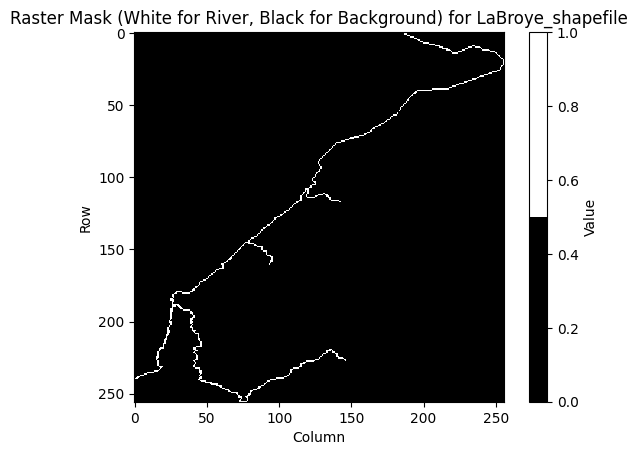

In [31]:
# Desired output size
output_shape = (256, 256)
binary_masks = []
for k, river in rivers.items():
    river_original = river.to_crs(original_crs)

    # Check the bounds of the filtered river geometries
    x_min, y_min, x_max, y_max = list(river_original.total_bounds)
    print(f"Bounds for {k}: {river_original.total_bounds}")
    
    # Create the transform for 256x256 grid based on the bounds
    grid_width = output_shape[1]  # 256 pixels for width
    grid_height = output_shape[0]  # 256 pixels for height
    x_res = (x_max - x_min) / grid_width
    y_res = (y_max - y_min) / grid_height

    transform = from_origin(x_min, y_max, x_res, y_res)

    # Convert the LineStrings to a list of geometries for rasterization
    line_geometries = river_original.geometry.values

    # Create a raster mask for the output shape (256x256)
    out_shape = output_shape
    raster_array = np.zeros(out_shape)

    # Rasterize each LineString into the grid
    for i, geom in enumerate(line_geometries):
        if geom.is_empty:
            print(f"Empty geometry for {k}, skipping.")
            continue
        shape = (geom, 1)  # Assign a value of 1 for each line
        temp_mask = rasterize([shape], out_shape=out_shape, transform=transform)
        raster_array += temp_mask

    # Binarize the raster
    binary_mask = np.where(raster_array > 0.0, 1.0, 0.0)
    print(f"Min value: {binary_mask.min()}")
    print(f"Max value: {binary_mask.max()}")
    print('shape:', binary_mask.shape)
    binary_masks.append(binary_mask)

    # Define a colormap (black for background, white for river)
    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
    
    # Display the rasterized mask with a custom colormap
    plt.imshow(binary_mask, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title(f'Raster Mask (White for River, Black for Background) for {k}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()

    # Save the raster
    save_raster(raster_array, f'../data/external/raster_masks/raster_mask_bw_{k}.tif', river)


#### Mask the water temperature data to Le Boiron river

 Quadrant mask to assign to its correspondent values

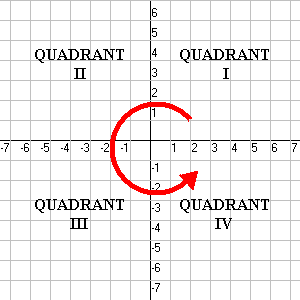

In [22]:
raw_data_path = '../data/raw/wt'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

In [23]:
for i, (k, river) in enumerate(rivers.items()):
    destination_folder = f'../data/raw/wt/{k}/'
    dates = list(closest_points['upper_right']['time'].unique())
    for d in dates:
        ur = closest_points['upper_right'][closest_points['upper_right'].time == d]
        ul = closest_points['upper_left'][closest_points['upper_left'].time == d]
        ll = closest_points['lower_left'][closest_points['lower_left'].time == d]
        lr = closest_points['lower_right'][closest_points['lower_right'].time == d]
        binary_mask = binary_masks[i]

        height, width = binary_mask.shape

        # Define los límites de los cuadrantes
        half_height = height // 2
        half_width = width // 2

        # Crea una máscara para cada cuadrante
        mask_q1 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q2 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q3 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q4 = np.zeros_like(binary_mask, dtype=np.float32)

        value_q1 = ur.waterTemperature  # Valor específico para el cuadrante 1
        value_q2 = ul.waterTemperature  # Valor específico para el cuadrante 2
        value_q3 = ll.waterTemperature  # Valor específico para el cuadrante 3
        value_q4 = lr.waterTemperature

        mask_q1[0:half_height, 0:half_width] = np.where(binary_mask[0:half_height, 0:half_width] > 0, value_q1, 0.0)
        mask_q2[0:half_height, half_width:] = np.where(binary_mask[0:half_height, half_width:] > 0, value_q2, 0.0)
        mask_q3[half_height:, 0:half_width] = np.where(binary_mask[half_height:, 0:half_width] > 0, value_q3, 0.0)
        mask_q4[half_height:, half_width:] = np.where(binary_mask[half_height:, half_width:] > 0, value_q4, 0.0)


        combined_mask = mask_q1 + mask_q2 + mask_q3 + mask_q4

        save_raster(raster_array, f'{destination_folder}raster_mask_temp_{d.strftime("%Y-%m")}.tif', river)


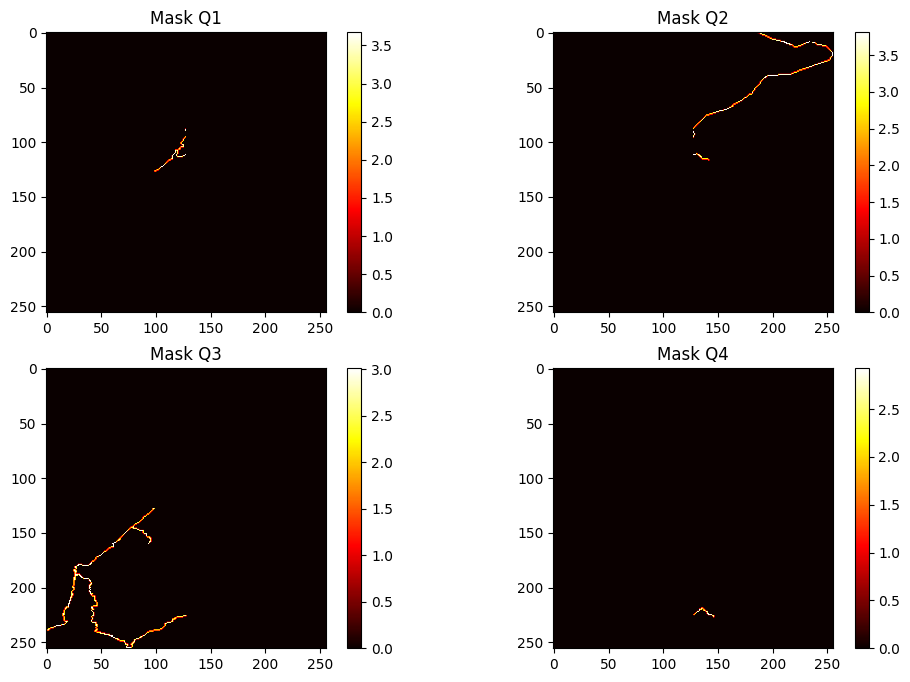

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Mask Q1')
plt.imshow(mask_q1, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Mask Q2')
plt.imshow(mask_q2, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Mask Q3')
plt.imshow(mask_q3, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Mask Q4')
plt.imshow(mask_q4, cmap='hot')
plt.colorbar()

plt.show()


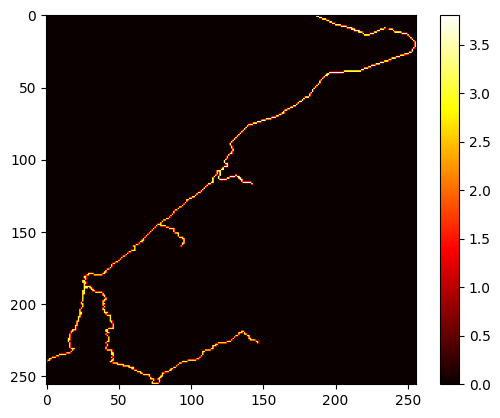

In [21]:
plt.imshow(combined_mask,cmap='hot')#, cmap='viridis')
plt.colorbar()
plt.show()

## Obtain NDVI images

In [26]:
evalscript_ndvi = """//VERSION=3

function setup() {
    return {

      input: [{
        bands: ["B04", "B05"],
      }],
      output: [{
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        },
        {
          id: "ndvi_image",
          bands: 3,
          sampleType: SampleType.AUTO
        }
      ]
    }
  }


  function evaluatePixel(sample) {
    let ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04)

    if (ndvi < -0.5) image = [0.05, 0.05, 0.05]
    else if (ndvi < -0.2) image = [0.75, 0.75, 0.75]
    else if (ndvi < -0.1) image = [0.86, 0.86, 0.86]
    else if (ndvi < 0) image = [0.92, 0.92, 0.92]
    else if (ndvi < 0.025) image = [1, 0.98, 0.8]
    else if (ndvi < 0.05) image = [0.93, 0.91, 0.71]
    else if (ndvi < 0.075) image = [0.87, 0.85, 0.61]
    else if (ndvi < 0.1) image = [0.8, 0.78, 0.51]
    else if (ndvi < 0.125) image = [0.74, 0.72, 0.42]
    else if (ndvi < 0.15) image = [0.69, 0.76, 0.38]
    else if (ndvi < 0.175) image = [0.64, 0.8, 0.35]
    else if (ndvi < 0.2) image = [0.57, 0.75, 0.32]
    else if (ndvi < 0.25) image = [0.5, 0.7, 0.28]
    else if (ndvi < 0.3) image = [0.44, 0.64, 0.25]
    else if (ndvi < 0.35) image = [0.38, 0.59, 0.21]
    else if (ndvi < 0.4) image = [0.31, 0.54, 0.18]
    else if (ndvi < 0.45) image = [0.25, 0.49, 0.14]
    else if (ndvi < 0.5) image = [0.19, 0.43, 0.11]
    else if (ndvi < 0.55) image = [0.13, 0.38, 0.07]
    else if (ndvi < 0.6) image = [0.06, 0.33, 0.04]
    else image = [0, 0.27, 0]

    return {
      default: [ndvi],
      ndvi_image: image
    }
  }"""

In [33]:
raw_data_path = '../data/raw/ndvi'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

#### Save images

In [34]:
import tarfile

for k, river in rivers.items():
    destination_folder = f'../data/raw/ndvi/{k}'
    get_data(river, evalscript_ndvi, slots, 'ndvi', destination_folder)
    counter = 0
    # Recorre todas las subcarpetas en la carpeta principal
    for subdir, dirs, files in os.walk(destination_folder):
        for file in files:
            # Si el archivo es un .tar
            if file.endswith('.tar'):
                print(f'Archivo {file} encontrado en {subdir}')
                # Construye la ruta completa del archivo tar
                tar_file_path = os.path.join(subdir, file)

                # Define el nuevo nombre de la carpeta donde se extraerán los archivos
                extract_folder_name = f'extracted_{slots[counter][0][:7]}'
                extract_folder_path = os.path.join(destination_folder, extract_folder_name)

                # Crea el directorio si no existe
                if not os.path.exists(extract_folder_path):
                    os.makedirs(extract_folder_path)

                # Abre y descomprime el archivo .tar
                with tarfile.open(tar_file_path, 'r') as tar:
                    tar.extractall(path=extract_folder_path)

                print(f'Archivo {file} descomprimido en {extract_folder_path}')

                # Busca el archivo .tif dentro de la carpeta descomprimida
                for root, dirs, extracted_files in os.walk(extract_folder_path):
                    for extracted_file in extracted_files:
                        if extracted_file.endswith('.tif'):
                            # Ruta completa del archivo .tif
                            tiff_file_path = os.path.join(root, extracted_file)

                            # Define la ruta de destino fuera de la carpeta
                            new_tiff_file_path = os.path.join(destination_folder, extracted_file)

                            new_file_name = f'ndvi_{slots[counter][0][:7]}.tiff'
                            new_file_path = os.path.join(destination_folder, new_file_name)

                            # Mueve el archivo .tif fuera de la carpeta descomprimida
                            shutil.move(tiff_file_path, new_file_path)

                            print(f'Archivo {extracted_file} movido a {new_file_path}')

                # Incrementa el contador
                counter += 1
                
    for subdir, dirs, files in os.walk(destination_folder):
        for dir in dirs:
            dir_path = os.path.join(subdir, dir)
            shutil.rmtree(dir_path, ignore_errors=True)


Archivo response.tar encontrado en ../data/raw/ndvi/LaVenoge_shapefile/2437bd1d8f1fc8c0f3321dd49c588224
Archivo response.tar descomprimido en ../data/raw/ndvi/LaVenoge_shapefile/extracted_2013-03
Archivo default.tif movido a ../data/raw/ndvi/LaVenoge_shapefile/ndvi_2013-03.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaVenoge_shapefile/31874f0c89635705fc7da9cbbd52bb9e
Archivo response.tar descomprimido en ../data/raw/ndvi/LaVenoge_shapefile/extracted_2013-04
Archivo default.tif movido a ../data/raw/ndvi/LaVenoge_shapefile/ndvi_2013-04.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaVenoge_shapefile/64d9bd247884362b7f4c3150c1bf6c97
Archivo response.tar descomprimido en ../data/raw/ndvi/LaVenoge_shapefile/extracted_2013-05
Archivo default.tif movido a ../data/raw/ndvi/LaVenoge_shapefile/ndvi_2013-05.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaVenoge_shapefile/e15f0b17563ac6ee2b00bc8553b7d01d
Archivo response.tar descomprimido en ../data/raw/ndvi/LaVe

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sentinelhub/download/sentinelhub_clien

Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/e9e62abc684601554dd5558427b18698
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2013-03
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2013-03.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/cbc2eddbef704b08161ba0de29c3cd59
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2013-04
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2013-04.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/55f63bee52d215ff3761e8ba442b64e7
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2013-05
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2013-05.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/faa82e7248a26560a71a87891ccd22f5
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapef